In [1]:
import numpy
from huggingface_hub import from_pretrained_keras

/Users/adhyyan/anaconda3/envs/modified_classification/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow import keras
from tensorflow.keras import layers

from tensorflow_docs.vis import embed
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import imageio

# Forward pass on cGan model

In [3]:
model = from_pretrained_keras("keras-io/conditional-gan")

config.json not found in HuggingFace Hub
2022-10-05 16:24:12.671382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
model.compile()

In [7]:
batch_size = 64
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128
num_interpolation = 12  # @param {type:"integer"}
trained_gen = model

In [30]:
# Sample noise for the interpolation.
interpolation_noise = tf.random.normal(shape=(1, latent_dim))
interpolation_noise = tf.repeat(interpolation_noise, repeats=num_interpolation)
interpolation_noise = tf.reshape(interpolation_noise, (num_interpolation, latent_dim))


def interpolate_class(first_number, second_number):
    # Convert the start and end labels to one-hot encoded vectors.
    first_label = keras.utils.to_categorical([first_number], num_classes)
    second_label = keras.utils.to_categorical([second_number], num_classes)
    first_label = tf.cast(first_label, tf.float32)
    second_label = tf.cast(second_label, tf.float32)
    
    # Calculate the interpolation vector between the two labels.
    percent_second_label = tf.linspace(0, 1, num_interpolation)[:, None]
    percent_second_label = tf.cast(percent_second_label, tf.float32)
    interpolation_labels = (
        first_label * (1 - percent_second_label) + second_label * percent_second_label
    )

    # Combine the noise and the labels and run inference with the generator.
    noise_and_labels = tf.concat([interpolation_noise, interpolation_labels], 1)
    fake = trained_gen.predict(noise_and_labels)
    return interpolation_labels, fake

In [31]:
start_class, end_class = 9, 2

labels, fake_images = interpolate_class(start_class, end_class)
fake_images *= 255.0
converted_images = fake_images.astype(np.uint8)
converted_images = tf.image.resize(converted_images, (96, 96)).numpy().astype(np.uint8)
imageio.mimsave("animation.gif", converted_images, fps=1)

1/1 [==============================] - 0s 41ms/step



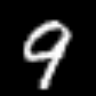

In [17]:
embed.embed_file("animation.gif")

# UMap on MNIST

In [18]:
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pandas
# Dimension reduction and clustering libraries
import umap.umap_ as umap
#import hdbscan
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [19]:
mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(int)

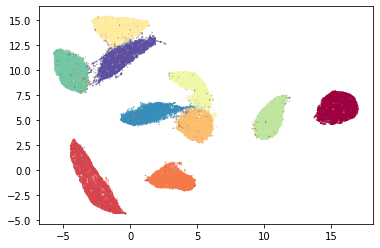

In [76]:
umap_instance = umap.UMAP(random_state=42)
standard_embedding = umap_instance.fit_transform(mnist.data)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');

# Generate the training images

In [73]:
from scipy.special import softmax

### Generate Images

In [163]:
num_new_samples = 50000

In [164]:
input_noise = tf.random.normal(shape=(num_new_samples, latent_dim))
#input_noise = tf.repeat(input_noise, repeats=num_new_samples)
input_noise = tf.reshape(input_noise, (num_new_samples, latent_dim))

In [165]:
def unif_in_simplex(n):
    '''
    Return uniformly random vector in the n-simplex 
    '''

    k = np.random.exponential(scale=1.0, size=n)
    return k / sum(k)

def calc_labels(image_embedding, cluster_centers):
    distances = [np.linalg.norm(image_embedding - e) for e in cluster_centers]
    return softmax(distances)

In [166]:
new_labels = []

for i in range(num_new_samples):
    label = unif_in_simplex(num_classes)
    new_labels.append(label)

new_labels = np.array(new_labels)

In [167]:
new_labels_tensor = tf.convert_to_tensor(new_labels, dtype = tf.float32)

In [168]:
noise_and_labels_new = tf.concat([input_noise, new_labels_tensor], 1)

In [169]:
fake_new = trained_gen.predict(noise_and_labels_new)

1563/1563 [==============================] - 75s 48ms/step


In [152]:
fake_new *= 255.0
converted_img_new = fake_new.astype(np.uint8)
converted_img_new = tf.image.resize(converted_img_new , (96, 96)).numpy().astype(np.uint8)

array([0.13192257, 0.08850855, 0.19281644, 0.07044545, 0.10078297,
       0.08239327, 0.09350807, 0.22355453, 0.00658527, 0.00948288])

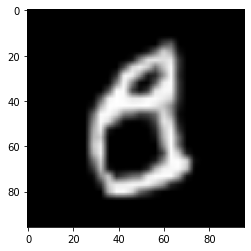

In [158]:
plt.imshow(converted_img_new[1111], cmap = 'gray')
new_labels[1111]

In [170]:
X_train_new = fake_new.reshape((num_new_samples, 784))
y_train_new = new_labels

In [171]:
np.save('./X_train_new', X_train_new)

In [172]:
np.save('./y_train_new', y_train_new)

### Compute labels

In [159]:
cluster_centers = []

In [160]:
new_embeddings = umap_instance.transform(X_train_new)

In [123]:
for i in range(num_classes):
    print(i)
    class_idx = (mnist.target == i)
    class_embeddings = standard_embedding[class_idx]
    class_center = np.mean(class_embeddings)
    cluster_centers.append(class_center)

0
1
2
3
4
5
6
7
8
9


In [124]:
labels_embedding = []

for i in range(num_new_samples):
    embedding = new_embeddings[i]
    label = calc_labels(embedding, cluster_centers)
    labels_embedding.append(label)

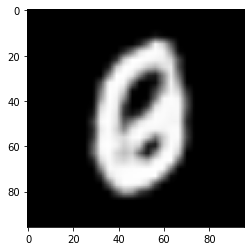

[2.1764073e-04 9.8152184e-01 1.4875961e-02 2.1323729e-04 3.9761395e-05
 4.2159525e-05 2.7822354e-05 2.1366407e-03 8.2420645e-04 1.0078949e-04]
[0.10976954 0.05130017 0.07485839 0.04043218 0.02504815 0.05953971
 0.37796726 0.17877397 0.01981227 0.06249835]


In [144]:
plt.imshow(converted_img_new[302], cmap = 'gray')
plt.show()
print(labels_embedding[302])
print(new_labels[302])

### Visualize

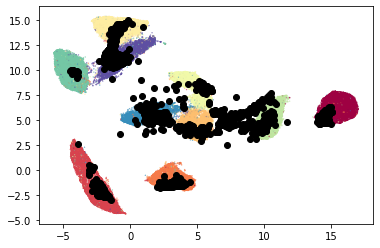

In [161]:
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=mnist.target.astype(int), s=0.1, cmap='Spectral');
plt.scatter(new_embeddings[:, 0], new_embeddings[:, 1], c = 'black')